In [16]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from cmcrameri import cm as cmc
from PIL import Image

from utils import robust_npreg

# load and example plot and show in matplotlib

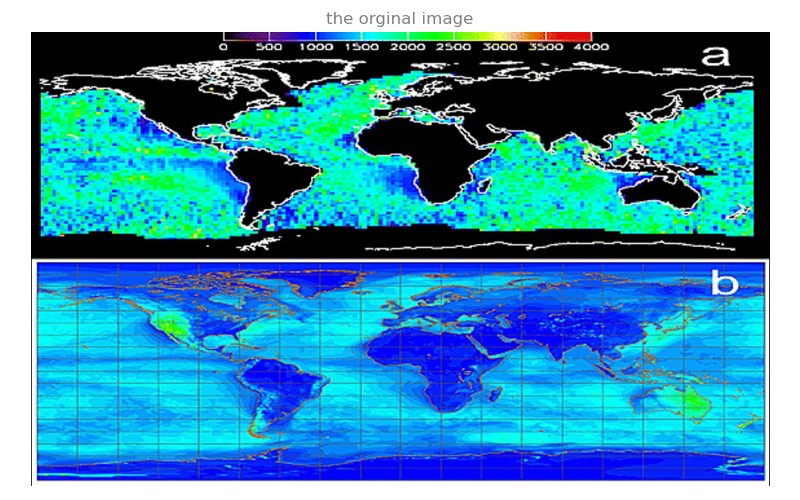

In [20]:
image = Image.open('example_plot.png',"r")
width, height = image.size
pixel_values = list(image.getdata())
if image.mode == "RGBA":
    channels = 4
if image.mode == "RGB":
    channels = 3
data = np.array(pixel_values).reshape((height, width, channels))
data = data[:,:,:3]

fig, ax = plt.subplots(figsize=[8,5])
ax.imshow(data)
ax.axis('off')
ax.set_title('the orginal image', c='gray')
fig.tight_layout(pad=1, w_pad=0, h_pad=0)
fig.patch.set_facecolor((0,0,0,0))
fig.savefig('plots/01.png', dpi=300)

In [3]:
ax.get_xlim()

(-0.5, 975.5)

In [4]:
ax.get_ylim()

(599.5, -0.5)

# set the x/y limits for the colorbar
use the figure above and ax.get_xlim() and ax.get_ylim to get these values

In [5]:
xl = [256, 739]
yl = [0, 10]

# Show the colorbar only

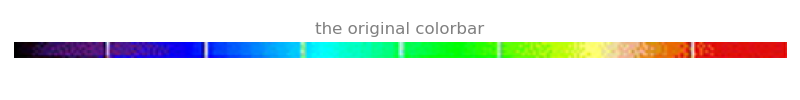

In [27]:
cbar = data[yl[0]:yl[1], xl[0]:xl[1], 0:3]
if cbar.shape[0] > cbar.shape[1]:
    cbar = np.transpose(cbar, axes=[1, 0, 2])

fig, ax = plt.subplots(figsize=[8,1])
ax.imshow(cbar)
ax.axis('off')
ax.set_title('the original colorbar', c='gray')
fig.tight_layout(pad=1, w_pad=0, h_pad=0)
fig.patch.set_facecolor((0,0,0,0))
fig.savefig('plots/02.png', dpi=300)

# take the mean across the shorter axis of the colorbar to reduce noise

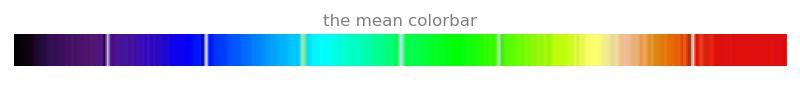

In [28]:
cbar_mean = np.mean(cbar,axis=0)
fig, ax = plt.subplots(figsize=[8,1])
cbar_mean_8bit = np.round(cbar_mean).astype(np.uint8)
ax.imshow(np.array([cbar_mean_8bit]*20))
ax.axis('off')
ax.set_title('the mean colorbar', c='gray')
fig.tight_layout(pad=1, w_pad=0, h_pad=0)
fig.patch.set_facecolor((0,0,0,0))

# fit a smooth line to the RGB values to clean up colormap
might need to tune the values of robust_npreg to get a fit

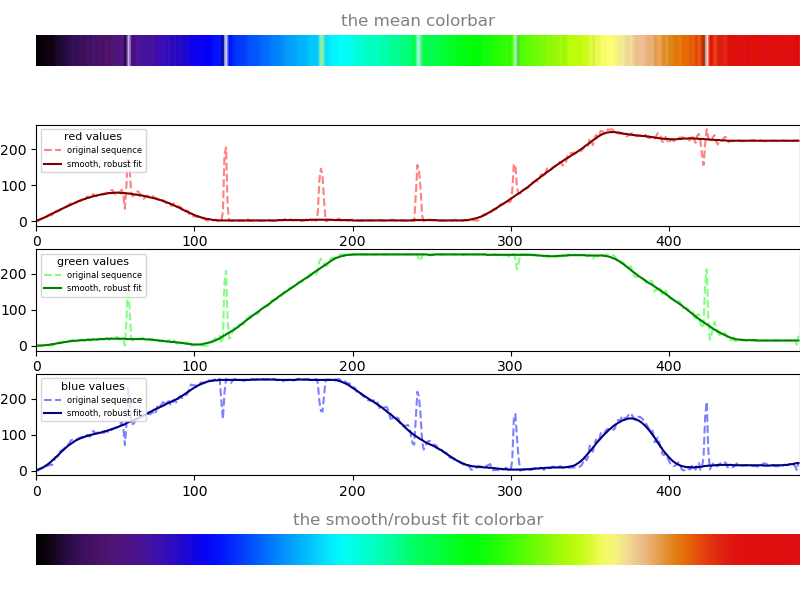

In [39]:
fig, axs = plt.subplots(figsize=[8,6], nrows=5)
cols = [np.array([1,0,0]), np.array([0,1,0]), np.array([0,0,1])]
ax = axs[0]
ax.imshow(np.array([cbar_mean_8bit]*20))
ax.axis('off')
ax.set_title('the mean colorbar', c='gray')
cbar_clean = []
tits = ['red values', 'green values', 'blue values']
for i in range(3):
    cvals = cbar_mean[:,i]
    df_fit = pd.DataFrame({'x': np.arange(len(cvals)), 'y': cvals})
    cvals_smooth = robust_npreg(df_fit, n_iter=10, poly_degree=1, frac_x=0.07, resolutions=[5,1], stds=[10,6])
    cvals_smooth = np.round(np.clip(cvals_smooth, 0, 255)).astype(np.uint8)
    cbar_clean.append(cvals_smooth)
    ax = axs[i+1]
    org, = ax.plot(cvals, color=cols[i]+(1-cols[i])/2, ls='--', label='original sequence')
    smooth, = ax.plot(cvals_smooth, color=cols[i]/2, label='smooth, robust fit')
    leg = ax.legend(handles=[org,smooth], loc='upper left', fontsize=6, title=tits[i])
    plt.setp(leg.get_title(),fontsize=8)
    ax.set_xlim((0,cbar_mean.shape[0]))

cbar_clean = np.transpose(np.array(cbar_clean))

ax = axs[4]
ax.imshow(np.array([cbar_clean]*20))
ax.axis('off')
ax.set_title('the smooth/robust fit colorbar', c='gray')

fig.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.patch.set_facecolor((0,0,0,0))
fig.savefig('plots/03.png', dpi=300)


In [40]:
first_value = [0,0,0]
cbar_clean = np.vstack((first_value, cbar_clean))

# show the cleaned-up smooth colorscale

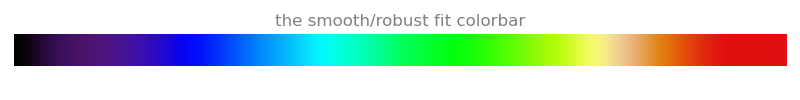

In [43]:
fig, ax = plt.subplots(figsize=[8,1])
ax.imshow(np.array([cbar_clean]*20))
ax.axis('off')
ax.set_title('the smooth/robust fit colorbar', c='gray')
fig.tight_layout(pad=1, w_pad=0, h_pad=0)
fig.patch.set_facecolor((0,0,0,0))

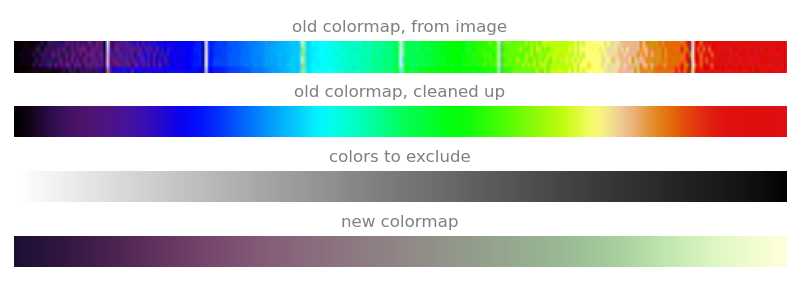

In [45]:
new_cmap = cmc.batlowK
new_cmap = cmc.tokyo
cbar_new = np.round(new_cmap(np.linspace(0,1,cbar_clean.shape[0]))[:,:3]*255).astype(np.uint8)
colors_to_exclude = np.round(cmc.grayC(np.linspace(0,0.99,100))[:,:3]*255).astype(np.uint8)
cbar_new_exc = np.vstack((cbar_new, colors_to_exclude))
cbar_new_exc[0,:] = first_value
cbar_clean_exc = np.vstack((cbar_clean, colors_to_exclude))

colorbar_thickness_px = 20 
fig, axs = plt.subplots(figsize=[8,3], nrows=4)
axs[0].imshow(cbar)
axs[0].axis('off')
axs[0].set_title('old colormap, from image', c='gray')
axs[0].set_aspect(colorbar_thickness_px / (yl[1] - yl[0]))
axs[1].imshow(np.array([cbar_clean]*colorbar_thickness_px))
axs[1].axis('off')
axs[1].set_title('old colormap, cleaned up', c='gray')
axs[2].imshow(np.array([colors_to_exclude]*colorbar_thickness_px))
axs[2].axis('off')
axs[2].set_title('colors to exclude', c='gray')
axs[2].set_aspect(colors_to_exclude.shape[0] / cbar_clean.shape[0])
axs[3].imshow(np.array([cbar_new]*colorbar_thickness_px))
axs[3].axis('off')
axs[3].set_title('new colormap', c='gray')
fig.tight_layout(pad=1, w_pad=0, h_pad=0)
fig.patch.set_facecolor((0,0,0,0))
fig.savefig('plots/04.png', dpi=300)

# find the nearest neighbor in the colormap and re-map to the new one
This is not very efficient. Here the code just loops through all the data points and calculates all the distances.

In [46]:
image_vals = data.reshape(-1, 3)
image_vals_old_clean = np.zeros_like(image_vals)
image_vals_new = np.zeros_like(image_vals)

for i in range(int(image_vals.shape[0])):
# for i in range(100000):
    if i%10000 == 0: 
        print('%3i %% progress...' % np.round(i/image_vals.shape[0]*100), end='\r')
    point = image_vals[i,:]
    distances = np.sqrt(np.sum((np.array([point]*cbar_clean_exc.shape[0]) - cbar_clean_exc)**2, axis=1))
    index_cmap = np.argmin(distances)
    image_vals_old_clean[i,:] = cbar_clean_exc[index_cmap,:]
    image_vals_new[i,:] = cbar_new_exc[index_cmap,:]

data_old = image_vals_old_clean.reshape(data.shape)
data_new = image_vals_new.reshape(data.shape)
print('\n ---> DONE!')

 99 % progress...
 ---> DONE!


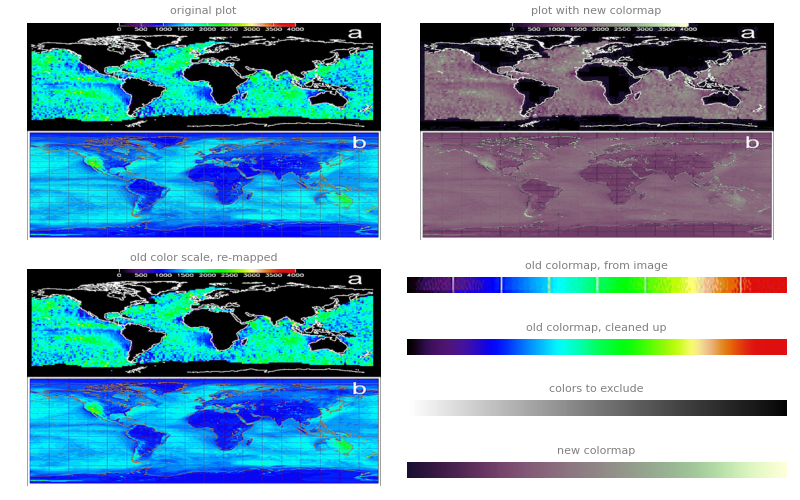

In [47]:
fig = plt.figure(figsize=[8,5])
gs = fig.add_gridspec(8, 2)

data_plot = data_new.copy()
yl_new = [0,13]
data_plot[yl_new[0]:yl_new[1], xl[0]:xl[1], 0:3] = np.array([cbar_new]*(yl_new[1]-yl_new[0]))[:,:cbar.shape[1],:]
data_old[yl_new[0]:yl_new[1], xl[0]:xl[1], 0:3] = np.array([cbar_clean]*(yl_new[1]-yl_new[0]))[:,:cbar.shape[1],:]

tit_sz = 8

ax = fig.add_subplot(gs[:4, 0])
ax.imshow(data)
ax.axis('off')
ax.set_title('original plot', c='gray', fontsize=tit_sz)

ax = fig.add_subplot(gs[4:, 0])
ax.imshow(data_old)
ax.axis('off')
ax.set_title('old color scale, re-mapped', c='gray', fontsize=tit_sz)

ax = fig.add_subplot(gs[:4, 1])
ax.imshow(data_plot)
ax.axis('off')
ax.set_title('plot with new colormap', c='gray', fontsize=tit_sz)

ax = fig.add_subplot(gs[4, 1])
ax.imshow(cbar)
ax.axis('off')
ax.set_title('old colormap, from image', c='gray', fontsize=tit_sz)
ax.set_aspect(colorbar_thickness_px / (yl[1] - yl[0]))

ax = fig.add_subplot(gs[5, 1])
ax.imshow(np.array([cbar_clean]*colorbar_thickness_px))
ax.axis('off')
ax.set_title('old colormap, cleaned up', c='gray', fontsize=tit_sz)

ax = fig.add_subplot(gs[6, 1])
ax.imshow(np.array([colors_to_exclude]*colorbar_thickness_px))
ax.axis('off')
ax.set_title('colors to exclude', c='gray', fontsize=tit_sz)
ax.set_aspect(colors_to_exclude.shape[0] / cbar_clean.shape[0])

ax = fig.add_subplot(gs[7, 1])
ax.imshow(np.array([cbar_new]*colorbar_thickness_px))
ax.axis('off')
ax.set_title('new colormap', c='gray', fontsize=tit_sz)

fig.tight_layout(pad=1, w_pad=1, h_pad=2)
fig.patch.set_facecolor((0,0,0,0))
fig.savefig('output_comparison.jpg', dpi=600)

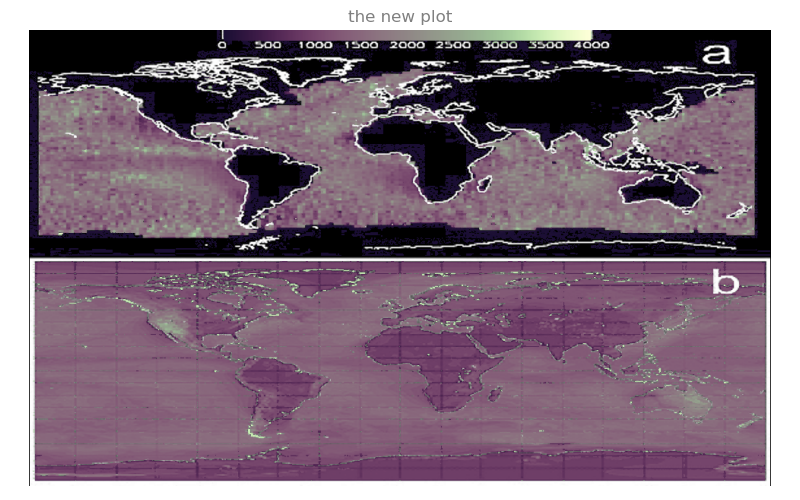

In [48]:
fig, ax = plt.subplots(figsize=[8,5])
data_plot = data_new.copy()
yl_new = [0,14]
data_plot[yl_new[0]:yl_new[1], xl[0]:xl[1], 0:3] = np.array([cbar_new]*(yl_new[1]-yl_new[0]))[:,:cbar.shape[1],:]
ax.imshow(data_plot)
ax.axis('off')
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.patch.set_facecolor((0,0,0,0))
fig.savefig('output_changed_colormap.jpg', dpi=300)

ax.set_title('the new plot', c='gray')
fig.tight_layout(pad=1, w_pad=0, h_pad=0)
fig.savefig('plots/05.png', dpi=300)

In [15]:
ax.get_ylim()

(599.5, -0.5)